🔄 Lade vorhandenes Modell...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


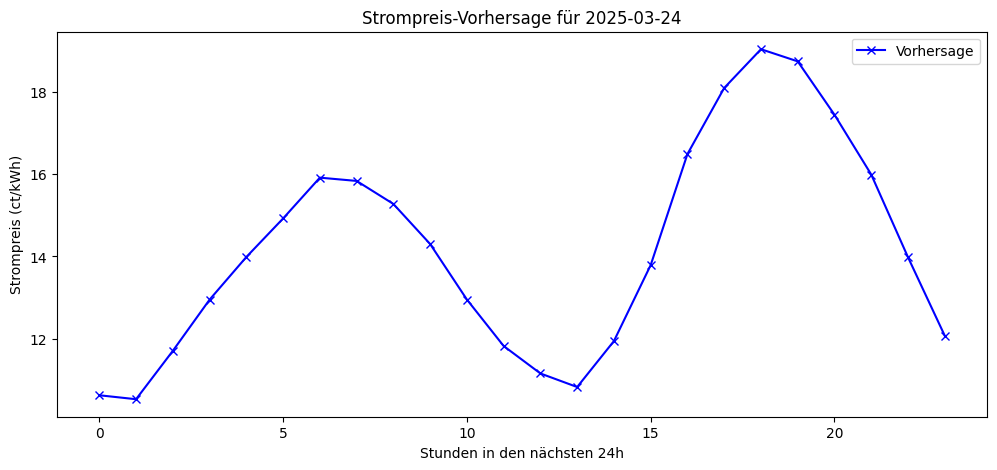

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from datetime import datetime, timedelta

# Dateipfad
file_path = "energy_prices_data.csv"
model_path = "energy_price_model.h5"  

# Lade die Daten
df = pd.read_csv(file_path, sep=';', decimal=',')
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M')
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)
df.set_index('Datetime', inplace=True)

# Normalisiere die Daten
scaler = MinMaxScaler(feature_range=(0, 1))
df['Spotpreis'] = scaler.fit_transform(df[['Spotpreis']])


# Sequenzen erstellen
def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)


seq_length = 336  # 14 Tage
output_length = 24  # 24 Stunden Vorhersage

# Konvertiere die Spotpreis-Daten in ein Array
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-Test-Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modell laden oder erstellen
if os.path.exists(model_path):
    print("🔄 Lade vorhandenes Modell...")
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
else:
    print("🆕 Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length) 
    ])
    model.compile(optimizer='adam', loss='mse')

# Falls Modell neu erstellt, trainiere es und speichere es
if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))
    model.save(model_path)  

latest_data = np.array([data[-seq_length:]])  # Nimm die letzten 14 Tage (336 Stunden)
latest_data = latest_data.reshape((1, seq_length, 1))  # Reshape für das Modell
predictions = model.predict(latest_data)  # Vorhersage für die nächsten 24 Stunden

# Transformiere die Vorhersage zurück auf den originalen Preisbereich
predictions = scaler.inverse_transform(predictions)

# Plot der Vorhersage
plt.figure(figsize=(12, 5))
plt.plot(predictions[0], label="Vorhersage", marker='x', color='b')
plt.xlabel("Stunden in den nächsten 24h")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


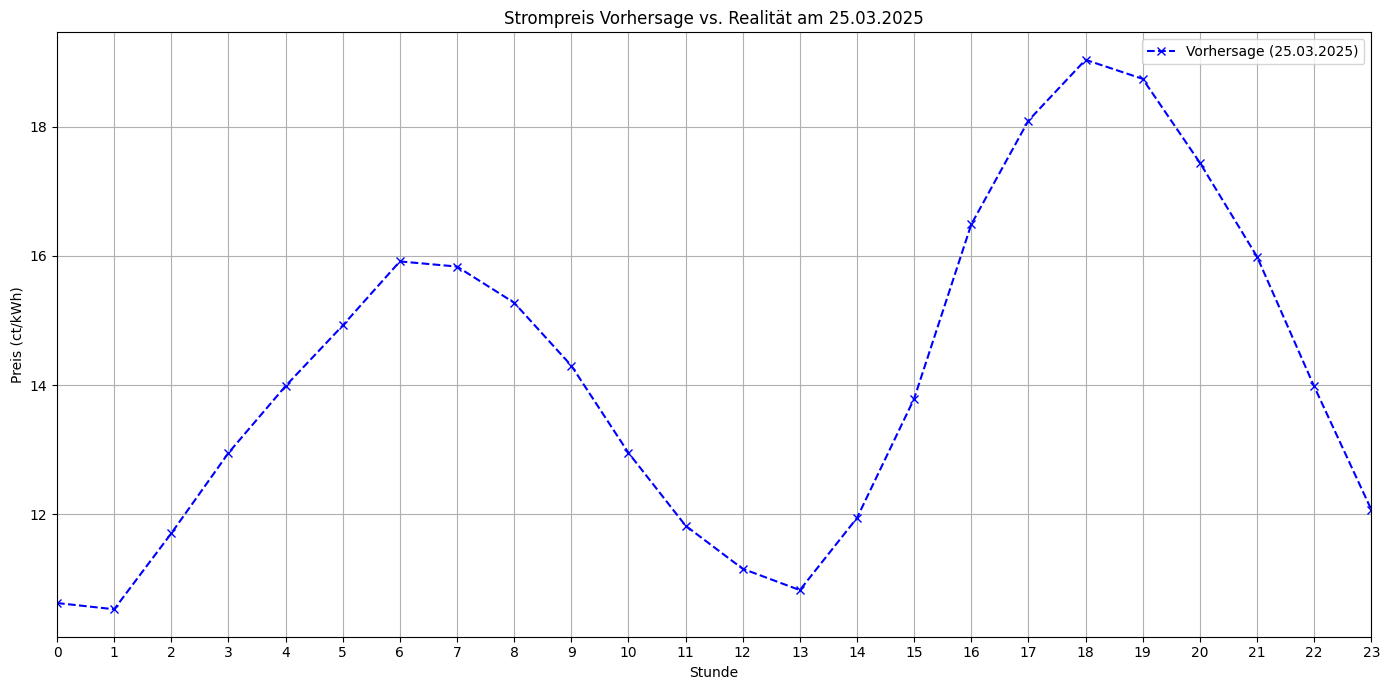

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Rückskalierung und Datenvorbereitung
actual_prices_today = scaler.inverse_transform(df['Spotpreis'][-24:].values.reshape(-1, 1))
latest_data = np.array([data[-seq_length:]])
latest_data = latest_data.reshape((1, seq_length, 1))
predictions_today = scaler.inverse_transform(model.predict(latest_data))[0]

# X-Achse von 0 bis 24 Stunden
hours = np.arange(24)

# Aktuelles Datum für den Titel
current_day_str = df.index[-1].strftime('%d.%m.%Y')

# Plot mit synchronisierter X-Achse
plt.figure(figsize=(14, 7))


# Plot der Vorhersage
plt.plot(hours, 
         predictions_today, 
         label=f"Vorhersage ({current_day_str})",
         linestyle='--', 
         marker='x',
         color='blue')

# Formatierung
plt.title(f"Strompreis Vorhersage vs. Realität am {current_day_str}")
plt.xlabel("Stunde")
plt.ylabel("Preis (ct/kWh)")
plt.xticks(np.arange(0, 25, 3))  # X-Achse in 3-Stunden-Schritten
plt.xlim(0, 23)  # Begrenzung von 0 bis 23 Uhr
plt.grid(True)
plt.legend()

# Feineinteilung der X-Achse auf ganze Stunden
plt.gca().xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


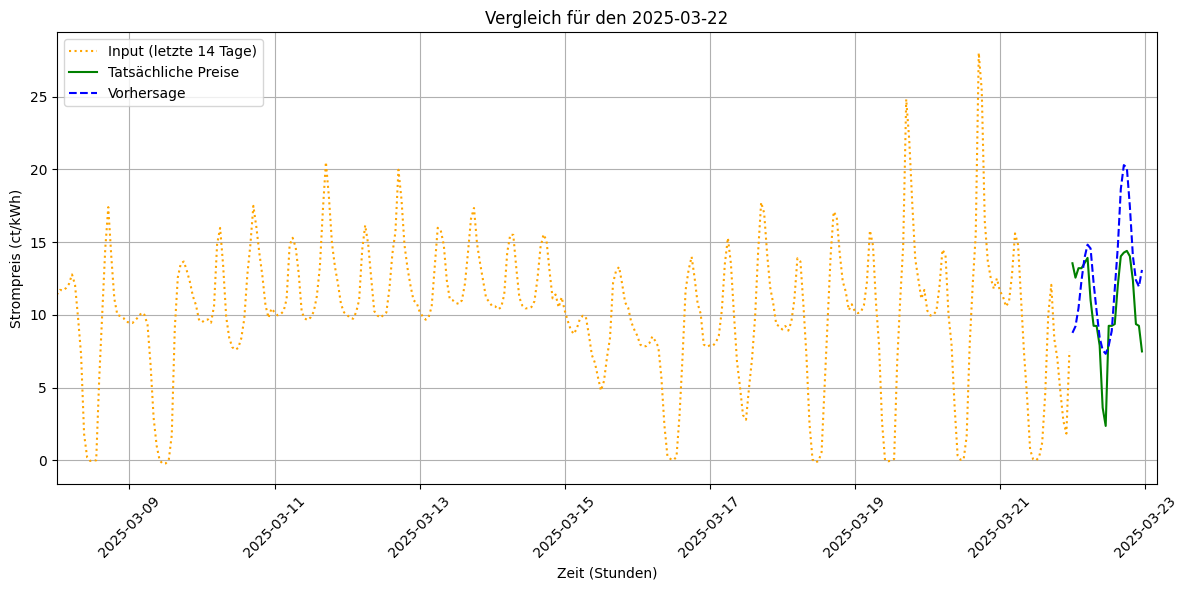

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

# Gewählter Tag und Vorbereitung der Daten
chosen_date = '2025-03-22'
start_date_input = pd.to_datetime(chosen_date) - timedelta(days=14)  # Startdatum 14 Tage vorher

# Tatsächliche Preise des gewählten Tages
actual_prices_day = df.loc[chosen_date].values
actual_prices_day = scaler.inverse_transform(actual_prices_day.reshape(-1, 1))

# Input-Daten (letzte 14 Tage vor chosen_date)
last_14_days_data = data[df.index < chosen_date][-seq_length:]
last_14_days_data = last_14_days_data.reshape((1, seq_length, 1))

# Vorhersage generieren
predictions_day = model.predict(last_14_days_data)
predictions_day = scaler.inverse_transform(predictions_day)

# Korrekte Generierung der Datumsbereiche
input_dates = pd.date_range(start=start_date_input, periods=seq_length, freq='h')  # 14 Tage vor chosen_date
prediction_dates = pd.date_range(start=chosen_date, periods=24, freq='h')         # 24h des gewählten Tages

# Plot
plt.figure(figsize=(12, 6))

# Input-Daten (letzte 14 Tage)
plt.plot(
    input_dates,
    scaler.inverse_transform(last_14_days_data[0].reshape(-1, 1)),
    label="Input (letzte 14 Tage)",
    color='orange',
    linestyle=':'
)

# Tatsächliche Preise und Vorhersage
plt.plot(prediction_dates, actual_prices_day, label="Tatsächliche Preise", color='g')
plt.plot(prediction_dates, predictions_day[0], label="Vorhersage", color='b', linestyle='--')

# Füge rechts noch etwas Platz hinzu, z.B. 2 Stunden
extra_time = timedelta(hours=5) 

# Setze die x-Achsen-Grenzen mit etwas zusätzlichem Platz auf der rechten Seite
plt.xlim([input_dates[0], prediction_dates[-1] + extra_time])


# Achsenbeschriftungen anpassen
plt.xlabel("Zeit (Stunden)")
plt.ylabel("Strompreis (ct/kWh)")
plt.title(f"Vergleich für den {chosen_date}")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Vorhersage auf dem Testdatensatz
y_pred = model.predict(X_test)

# Rücktransformation der Vorhersagen und echten Werte
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Berechnung des Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, y_pred)

# Berechnung des Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Ausgabe der Metriken
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


715/715 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
Mean Squared Error (MSE): 30.757024266186775
Root Mean Squared Error (RMSE): 5.545901573791837


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


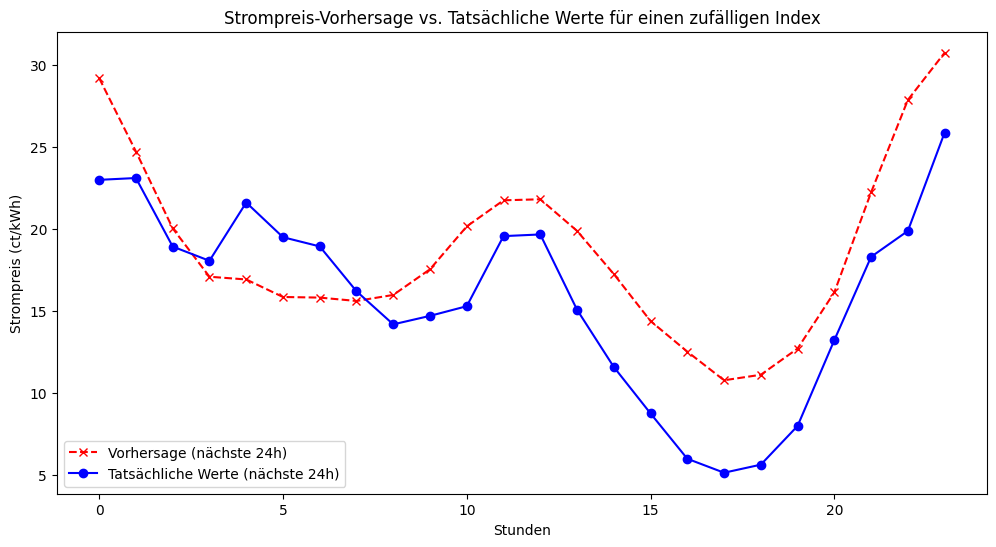

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Holen des Index für die aktuellen 24 Stunden (der letzte Testdatensatz für den heutigen Tag)
today = datetime.now().strftime('%Y-%m-%d')

# Gehe davon aus, dass die Zeitstempel der tatsächlichen Daten mit den Vorhersage-Daten übereinstimmen
today_data = df[df.index.date == datetime.today().date()]  # Aktuelle Daten für heute
today_data = today_data[['Spotpreis']]  # Nur Spotpreise (kWh)

# Wählen eines zufälligen Index im Testdatensatz (der heutigen Stunde)
random_index = np.random.randint(0, len(X_test)) 

# Hole die Eingabedaten und die tatsächlichen Ausgabewerte (y_test) für den zufälligen Index
input_data = X_test[random_index]
true_values = y_test[random_index]

# Mache eine Vorhersage für diesen Index
prediction = model.predict(input_data.reshape(1, seq_length, 1))

# Rücktransformation der Vorhersage und der tatsächlichen Werte
prediction = scaler.inverse_transform(prediction)
true_values = scaler.inverse_transform(true_values.reshape(1, -1))

# Plot der Vorhersage und der tatsächlichen Werte
plt.figure(figsize=(12, 6))

# Plot für die Vorhersage
plt.plot(range(24), prediction[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot für die tatsächlichen Werte
plt.plot(range(24), true_values[0], label="Tatsächliche Werte (nächste 24h)", marker='o', linestyle='-', color='blue')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage vs. Tatsächliche Werte für einen zufälligen Index")

# Anzeigen des Plots
plt.show()
